# Assignment 3: Waves Across the Pacific

For this assignment, we are getting into the mind of the scientists who conducted the study documented by the film _Waves across the Pacific_ in the 1960s, who thought of the Pacific as a basin in which ocean surface waves (in particular swells) propogate. 

For this assignment, you will need a netCDF file `JRA_wind_1963.nc` that contains historic wind map of the year 1963, and a few matlab data files `spectrum_at_XXX.mat` that contain simulated wave spectrum at selected locations. All of them are in the folder `/home/ENV330/data/assignment3_data`. To copy them to your home directory, use `cp -r /home/ENV330/data/assignment3_data ./` after logging in, or use the MyAdroit GUI. 


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation, FFMpegWriter
import xarray as xr
import cartopy.crs as ccrs
import scipy.io
import cftime
import datetime as dt
import pandas as pd

## Let's get to know a bit the places and people involved in this experiment across the Pacific!
 <span style="color:blue">__Exercise 1__</span> __Read section 2 of [*Propogation of Ocean Swell Across the Pacific*](https://royalsocietypublishing.org/doi/10.1098/rsta.1966.0022)__ that describes the locations of the observation stations, the various factors that led to the choices, the instruments and workflow, and the people that were credited for making this observational campaign possible. 
 
<span style="color:blue">1.1</span> What kind of details of the whole campaign were most striking to you (there are definitely many to me) and why?

<span style="color:blue">1.2</span> Pick one of the station, search for a more up-to-date map of it (using e.g. satellite image Google map). What does it mean for the area to be ''favorably exposed''? (Think in the context of the measurement they were making.) Write a short paragraph about the current population/culture/infrastructure of the island or region where the station is. Imagine how it would be like to be stationed there for 2 and a half months back then in the 60s (and write a fictional paragraph of your day as a scientist on the islands if you want).

<span style="color:blue">1.3</span> Why were two pressure gauges placed at the Honolulu station? Why were two pressure gauges installed on Flip?

## Simulating the wave spectrum using WAVEWATCHIII

### About the WAVEWATCHIII model
[WAVEWATCHIII](https://polar.ncep.noaa.gov/waves/wavewatch/) is a third generation wave model developed at NOAA/NCEP. It solves the random phase __spectral action density balance equation__ for wavenumber-direction spectra. Spectral action density equation (see Janssen 2004, pdf on canvas) is a partial differential equation for each (discrete) wave frequency, that takes into account wave kinematics (advection and refraction of wave energy) and various source terms (wind input, non-linear interaction between difference frequencies, and dissipation, etc.).

Fun fact: [Klaus Hasselmann](http://www.hvonstorch.de/klima/Media/interviews/hasselmann.pdf), the 2021 Nobel laureate in Physics, and coauthor of this paper, worked on the non-linear interaction of ocean waves, which he described as a more solvable probelm after "struggling" with his PhD thesis on turbulence theory. He later moved on to working in quantum field theory, and physical modelling of Earth’s climate (for which he won the Nobel prize).

Reference: [WAVEWATCHIII Manual](https://polar.ncep.noaa.gov/waves/wavewatch/manual.v5.16.pdf) (You are definitely not required to read it but I would browse through the table of content for fun.) 

### About historic wind map of year 1963
We take the 1963 wind map from the [Japanese 55-year Reanalysis (JRA) data base](https://jra.kishou.go.jp/JRA-55/index_en.html). You can run the cell below to generate the wind map animation for a selected duration in 1963. The resolution of this re-analyzed wind map is not that high, only about  $0.5^{\circ}$ (azimuthal degree of earth as a globe).

<span style="color:blue">2.1</span> What is $0.5^{\circ}$ in terms of kilometers? Approximately how many degrees does New Jersey span? [A cool visualization of earth system model resolution](https://vimeo.com/27076776).

Wind is the biggest source of energy for ocean surface waves. It's of crucial importance in forcing the wind waves and forming swells. Therefore, despite our efforts to reproduce the swells that travel across the Pacific using the historic wind record, the results may not be accurate due to limited wind information. 


<IPython.core.display.Javascript object>


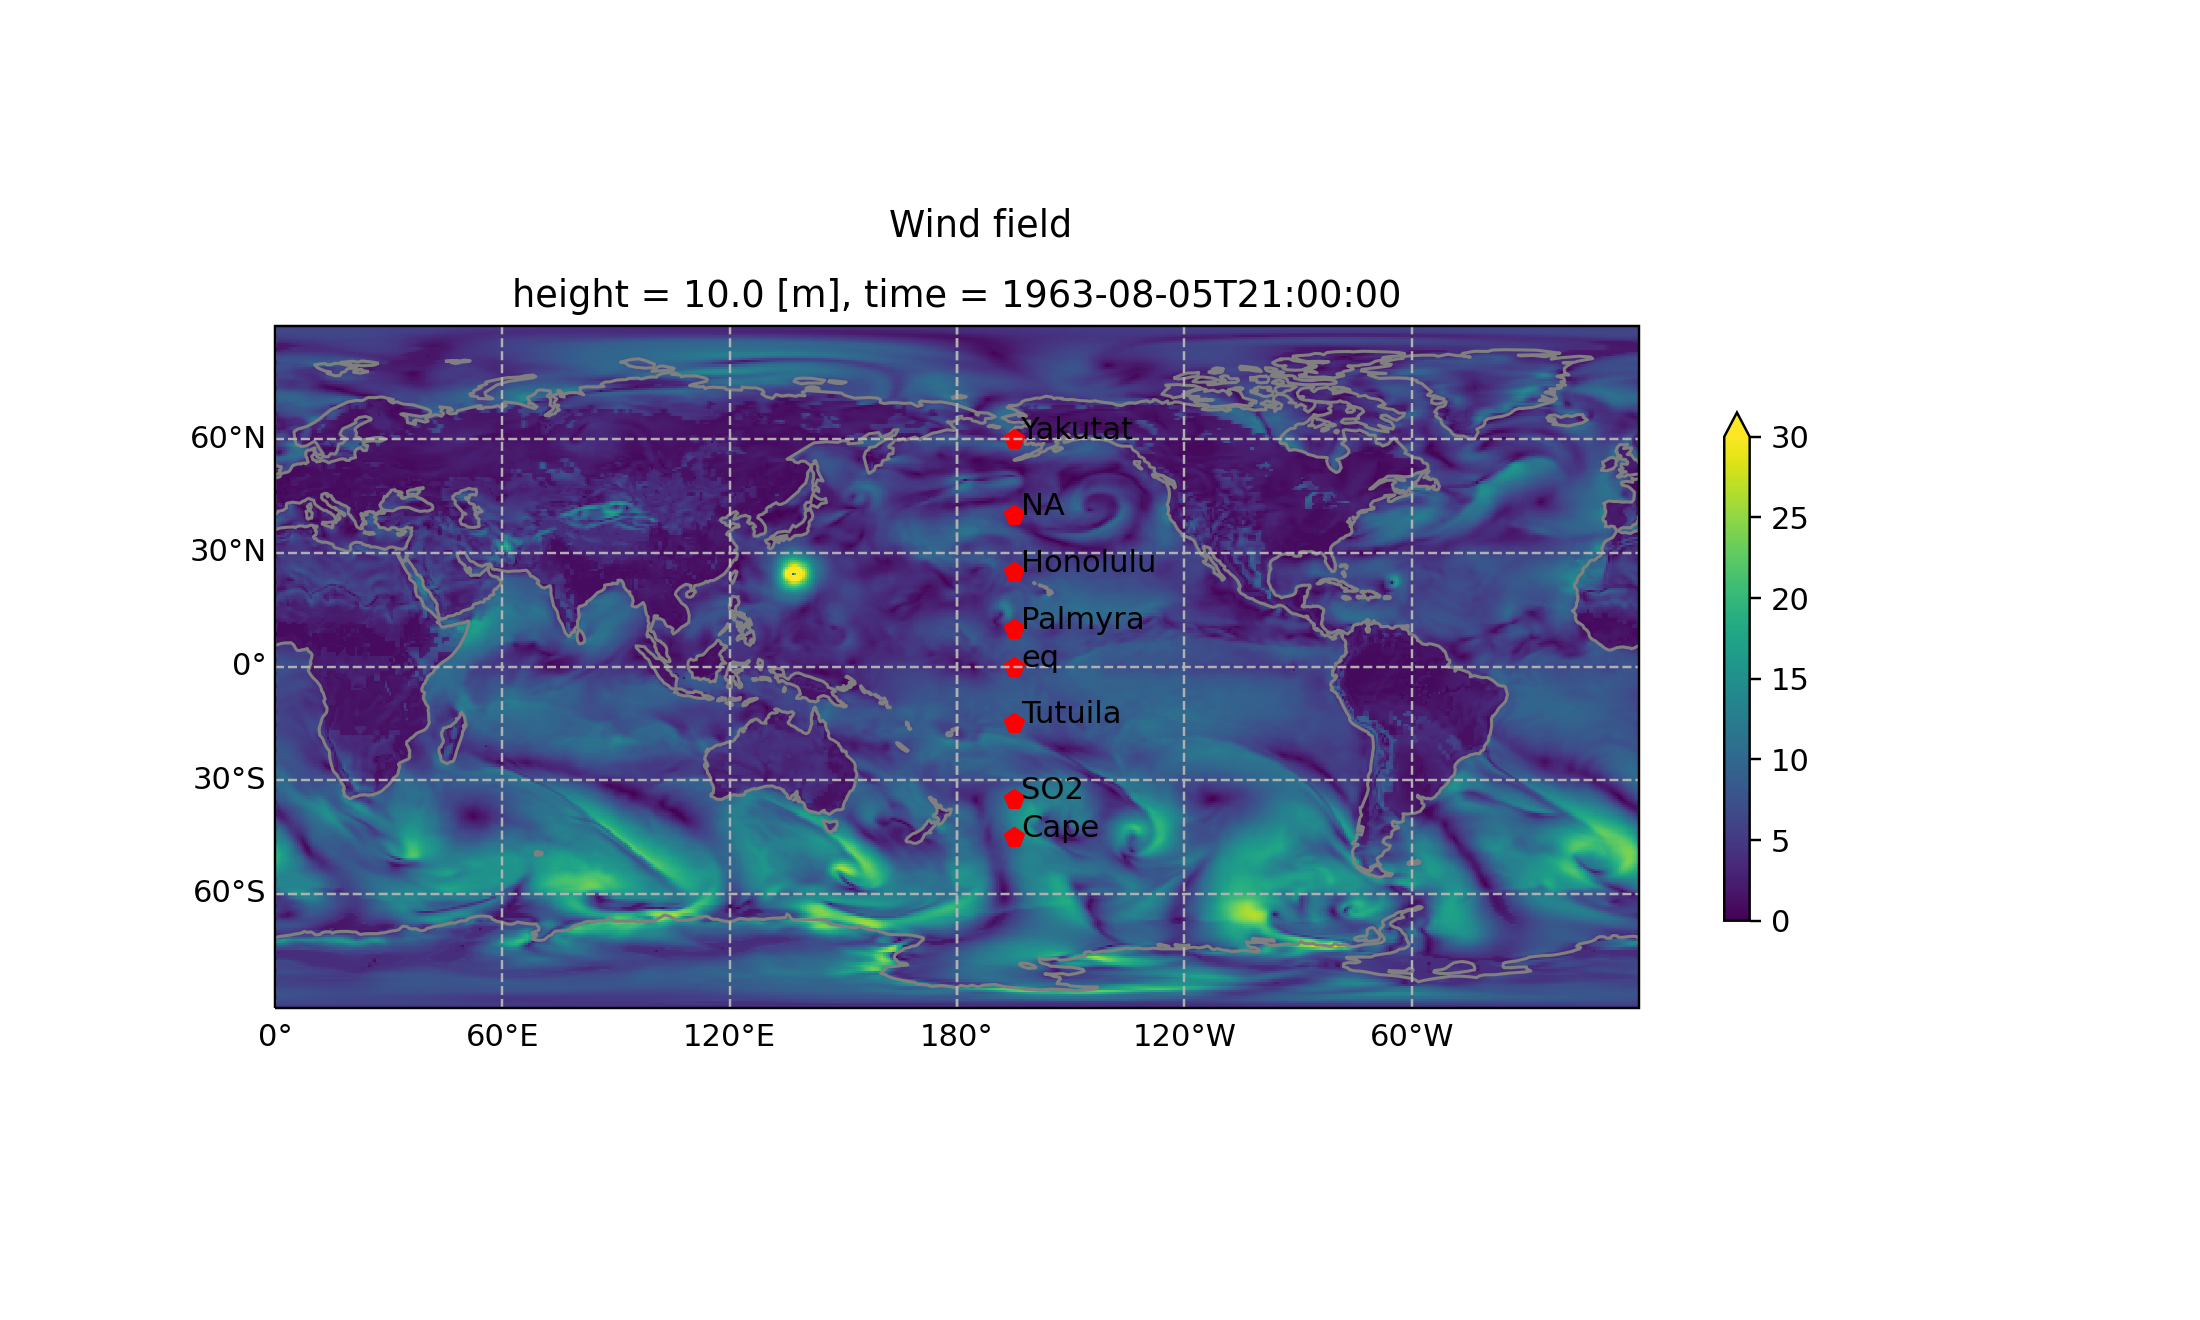

In [2]:
''' Generate an animation of the wind map, this might take a few minutes if you pick a several day duration '''
%matplotlib notebook

data_folder='./assignment3_data/' # where the JRA file is RELATIVE to where this notebook is
ds_wind=xr.open_dataset(data_folder+'JRA_wind_1963.nc') # You need to copy this file over 
spec_wind=ds_wind.sel(time=slice('1963-08-4','1963-08-5')) # Pick the starting and ending dates
u10=spec_wind['uas']
v10=spec_wind['vas']
lon=spec_wind['lon']
lat=spec_wind['lat']
time=spec_wind['time']
windspeed = np.sqrt(u10**2+v10**2)
X, Y = np.meshgrid(lon, lat)

lon_YAKUTAT=195
lat_YAKUTAT=60
lon_NA=195
lat_NA=40
lon_Honolulu=195
lat_Honolulu=25
lon_Palmyra=195
lat_Palmyra=10
lon_eq=195
lat_eq=0
lon_Tutuila=195
lat_Tutuila=-15
lon_SO2=195
lat_SO2=-35
lon_Cape=195
lat_Cape=-45
Lon_all=[195,195,195,195,195,195,195,195]
Lat_all=[lat_Cape,lat_SO2,lat_Tutuila,lat_eq,lat_Palmyra,lat_Honolulu,lat_NA,lat_YAKUTAT]

fig = plt.figure(figsize=(10,6))

def update(frame):
    plt.clf()
    
    # check the snaphot of wind field at Aug 1st, there was a storm generating at station Cape    
    ax = plt.axes(projection=ccrs.PlateCarree(
        central_longitude=180))

    ax.stock_img()
    ax.coastlines(resolution='auto',color='.5')
    ax.plot(Lon_all,Lat_all,transform=ccrs.PlateCarree(),marker='p',color='r',
                markerfacecolor='r',
                markeredgecolor='r',
                linestyle = 'none')
    gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle='--')
    gl.top_labels = False
    gl.right_labels=False
    ax.annotate('Wind field',fontsize=12, xy=(0.45, 1.13),xycoords="axes fraction",color='k')
    
    # station locations
    plt.text(196-180+1,lat_Cape,'Cape')
    plt.text(196-180+1,lat_SO2,'SO2')
    plt.text(196-180+1,lat_Tutuila,'Tutuila')
    
    plt.text(196-180+1,lat_eq,'eq')
    plt.text(196-180+1,lat_Palmyra,'Palmyra')
    plt.text(196-180+1,lat_Honolulu,'Honolulu')   
    plt.text(196-180+1,lat_NA,'NA') 
    plt.text(196-180+1,lat_YAKUTAT,'Yakutat')  
    
    wind_map = windspeed.isel(time=frame).plot(x="lon", y="lat", 
                                               transform=ccrs.PlateCarree(),cbar_kwargs=dict(shrink=0.5), 
                                               vmax=30, vmin=0)
    
ani = FuncAnimation(fig, update, frames=range(spec_wind['time'].shape[0]),repeat=False)
ani.save('wind_maps.mp4',FFMpegWriter(fps=30)) # Save the video if so wish 

In [3]:
''' If so wish, find out the wind speed at location closest to that given by lon and lat at a particular day and time
    The times are given by the 'daytime' index every 3 hrs, 0 for 12 am, 1 for 3 am, 2 for 6 am, etc.. '''
lon_Tutuila = 195
lat_Tutuila = -15 
lon = lon_Tutuila
lat = lat_Tutuila

spec_wind = ds_wind.sel(time=slice('1963-08-3','1963-08-3'))
u10=spec_wind['uas']
v10=spec_wind['vas']
windspeed = np.sqrt(u10**2+v10**2)
daytime = 2 # time in the day (every 3 hrs)
index_lon = np.absolute(spec_wind.isel(time=daytime)['lon']-lon).argmin()
index_lat = np.absolute(spec_wind.isel(time=daytime)['lat']-lat).argmin()
ws = windspeed.isel(time=daytime,lon=index_lon,lat=index_lat)
print('Time: ' + str(spec_wind['time'][daytime].values) + ' Wind speed (m/s): %g' %ws.values)

spec_wind = ds_wind.sel(time=slice('1963-08-5','1963-08-5'))
u10=spec_wind['uas']
v10=spec_wind['vas']
windspeed = np.sqrt(u10**2+v10**2)
daytime = 0 # time in the day (every 3 hrs)
index_lon = np.absolute(spec_wind.isel(time=daytime)['lon']-lon).argmin()
index_lat = np.absolute(spec_wind.isel(time=daytime)['lat']-lat).argmin()
ws = windspeed.isel(time=daytime,lon=index_lon,lat=index_lat)
print('Time: ' + str(spec_wind['time'][daytime].values) + ' Wind speed (m/s): %g' %ws.values)

Time: 1963-08-03T06:00:00.000000000 Wind speed (m/s): 7.72823
Time: 1963-08-05T00:00:00.000000000 Wind speed (m/s): 8.26039


### Let's analyze the spectrum output of the WAVEWATCHIII model

A few notes:
* The stations we extract the data are not their actual locations. They are at the same longitude ($195^{\circ}$) and somewhat evenly spaced in their latitudes (printed out in the cell below).
* The unit for frequency in the 1966 paper is mc/s, and 1 Hz = 1000 mc/s.
* There are 25 discrete frequencies we simulated between 41 - 406 mc/s, although in some plots we truncate the range to have better visualization of the range of interest. 

In [4]:
''' Load the spectrum data and print out their duration '''
data_folder='./assignment3_data/' # where the spectrum files are RELATIVE to where this notebook is
data_SO2 = scipy.io.loadmat(data_folder + 'spectrum_at_SO2.mat')
data_TUTU = scipy.io.loadmat(data_folder + 'spectrum_at_Tutuila.mat')
data_EQ = scipy.io.loadmat(data_folder + 'spectrum_at_eq.mat')
data_PALM = scipy.io.loadmat(data_folder + 'spectrum_at_Palmyra.mat')
data_HONO = scipy.io.loadmat(data_folder + 'spectrum_at_Honolulu.mat')
print('At "South Ocean", latitude: -35 degree, start: ' 
      + str(pd.to_datetime(data_SO2['time'][0,0]-719529,unit='d')) + ', end: ' 
      + str(pd.to_datetime(data_SO2['time'][-1,0]-719529,unit='d')))
print('At "Tutuila", latitude: -15 degree, start: '
      + str(pd.to_datetime(data_TUTU['time'][0,0]-719529,unit='d')) + ', end: ' 
      + str(pd.to_datetime(data_TUTU['time'][-1,0]-719529,unit='d')))
print('At "Equator", latitude: 0 degree, start: '  
      + str(pd.to_datetime(data_EQ['time'][0,0]-719529,unit='d')) + ', end: ' 
      + str(pd.to_datetime(data_EQ['time'][-1,0]-719529,unit='d')))
print('At "Palmyra", latitude: 10 degree, start: '
      + str(pd.to_datetime(data_PALM['time'][0,0]-719529,unit='d')) + ', end: '
      + str(pd.to_datetime(data_PALM['time'][-1,0]-719529,unit='d')))
print('At "Honolulu", latitude: 25 degree, start: ' 
      + str(pd.to_datetime(data_HONO['time'][0,0]-719529,unit='d')) + ', end: ' 
      + str(pd.to_datetime(data_HONO['time'][-1,0]-719529,unit='d')))

At "South Ocean", latitude: -35 degree, start: 1963-08-02 00:00:00, end: 1963-08-04 00:00:00
At "Tutuila", latitude: -15 degree, start: 1963-08-03 03:00:00, end: 1963-08-06 00:00:00
At "Equator", latitude: 0 degree, start: 1963-08-05 00:00:00, end: 1963-08-07 00:00:00
At "Palmyra", latitude: 10 degree, start: 1963-08-05 00:00:00, end: 1963-08-07 00:00:00
At "Honolulu", latitude: 25 degree, start: 1963-08-05 12:00:00, end: 1963-08-09 12:00:00


<IPython.core.display.Javascript object>


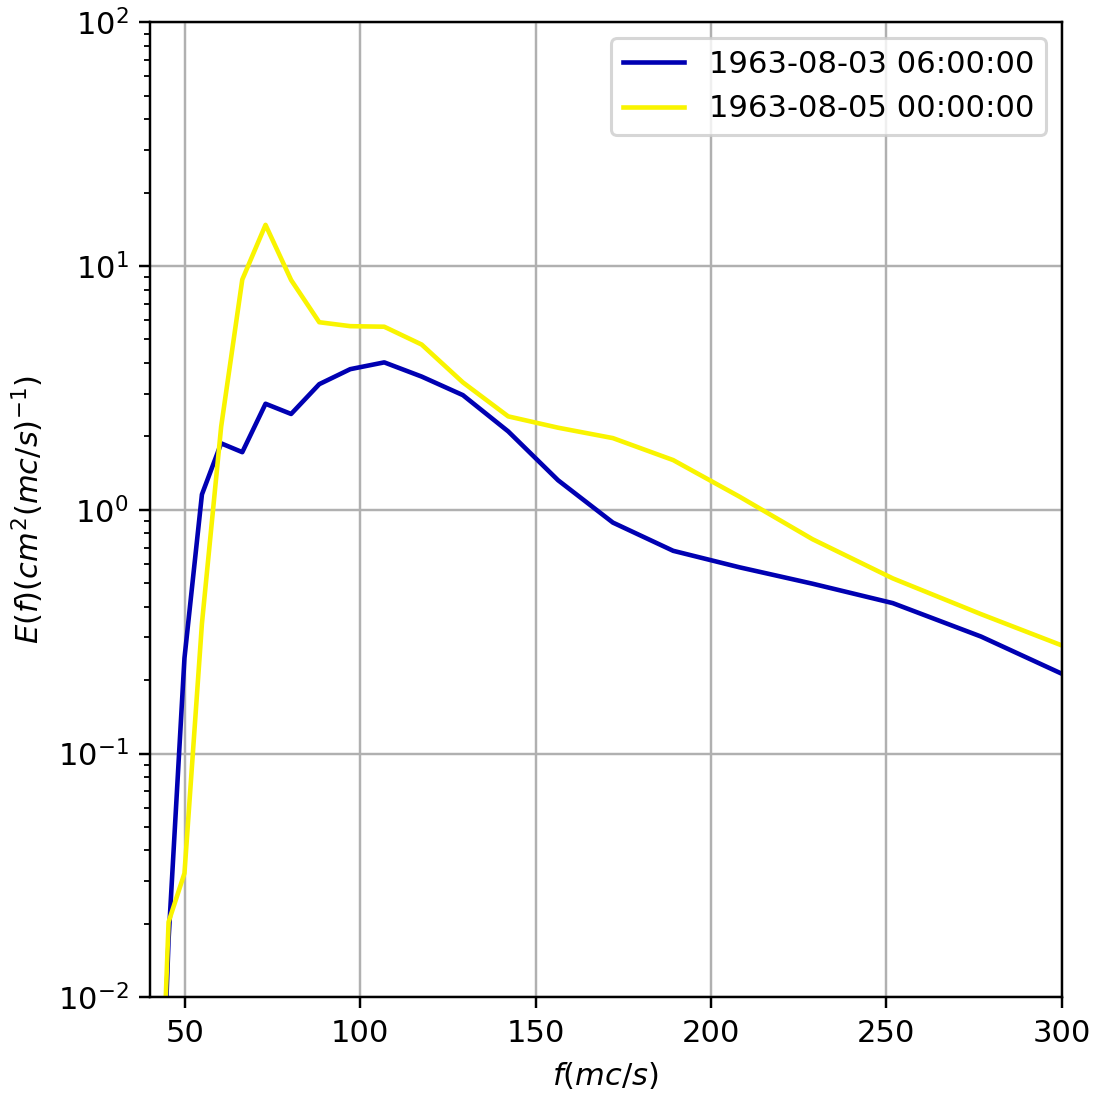

In [6]:
fig = plt.figure(2, figsize=[5,5], constrained_layout=True); ax = plt.gca()

data = data_TUTU
cmap = mpl.cm.get_cmap('jet', data['time'].shape[0])
time_arr = pd.to_datetime(data['time'][:,0]-719529,unit='d').round('s')

it = 1
ax.plot(data['fre']*1000, data['efth_Ef'][:,it]*10, color=cmap(it), label=time_arr[it])
it = 15
ax.plot(data['fre']*1000, data['efth_Ef'][:,it]*10, color=cmap(it), label=time_arr[it])

ax.set_ylabel('$E(f) (cm^2 (mc/s)^{-1}$)')
ax.set_xlabel('$f (mc/s)$')
ax.set_xlim(40,300)
ax.set_yscale('log')
ax.set_ylim([10**(-2), 10**2])
ax.grid(True)
plt.legend()
plt.show()

Visualize the wave gauge signal that might have given rise to these two spectra:

<IPython.core.display.Javascript object>


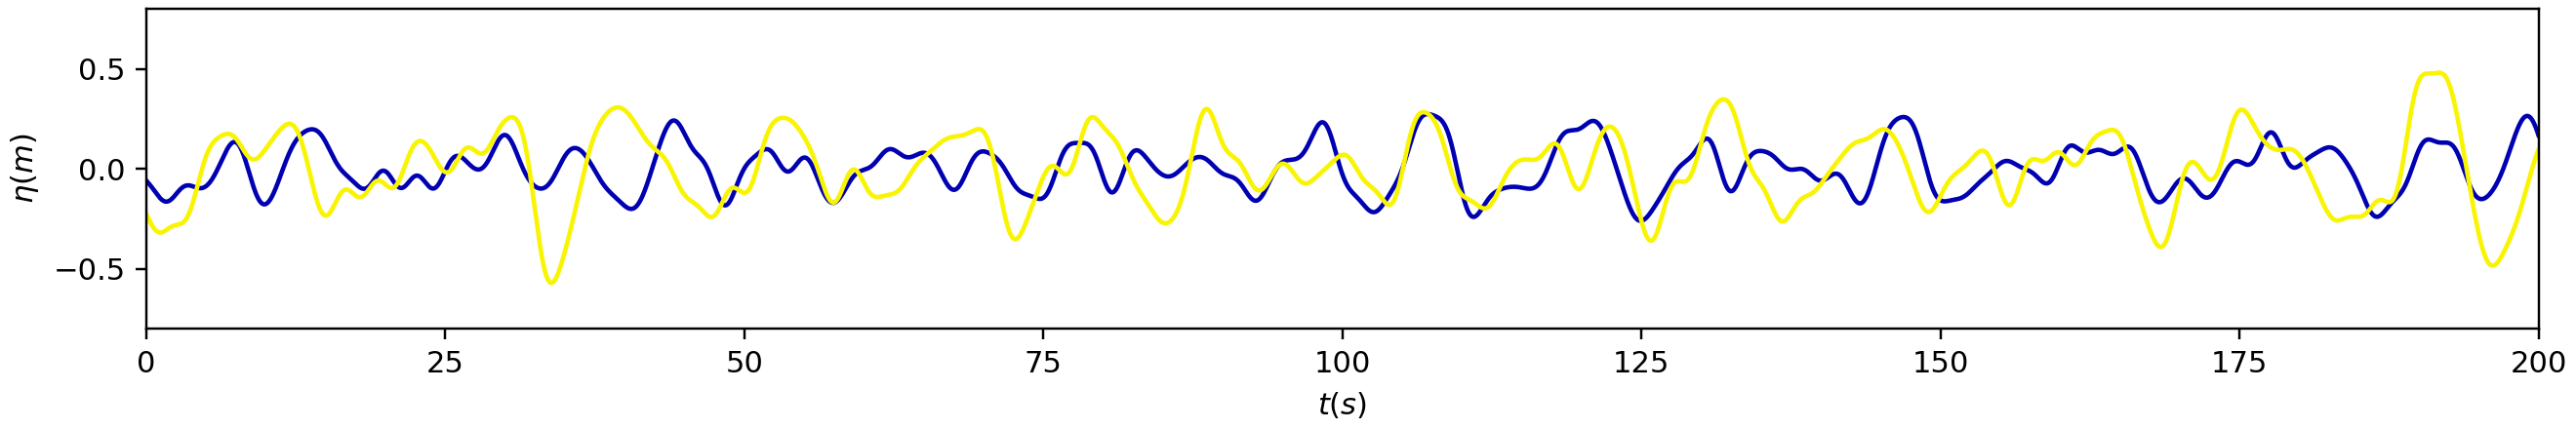

In [7]:
''' What the time signal might have looked like (just by summing cosine waves of random phase together) '''
import time 
def eta_random(f, Ef, seed):
    Nf = len(f)
    df = f[1] - f[0]   
    np.random.seed(seed)    
    phase = np.random.random_sample(Nf)*2*np.pi # Add a random phase field  
    tsample = np.arange(0,200,0.001)
    eta = np.zeros(len(tsample))
    for i in range (0,Nf):
        ampl = (2*Ef[i]*df)**0.5
        mode = ampl*np.cos(2*np.pi*f[i]*tsample + phase[i]) # uniform spacing in kx and ky
        eta = eta + mode  
    return tsample, eta

fig = plt.figure(3, figsize=[12,2], constrained_layout=True); ax = plt.gca()
cmap = mpl.cm.get_cmap('jet', data['time'].shape[0])

it = 1
tsample, eta = eta_random(data['fre'], data['efth_Ef'][:,it], seed=1)
ax.plot(tsample, eta, color=cmap(it), label=time_arr[it])
it = 15
tsample, eta = eta_random(data['fre'], data['efth_Ef'][:,it], seed=2)
ax.plot(tsample, eta, color=cmap(it), label=time_arr[it])

ax.set_ylim([-0.8,0.8])
ax.set_ylabel(r'$\eta (m)$')
ax.set_xlim([0, 200])
ax.set_xlabel(r'$t (s)$')
plt.show()


<span style="color:blue">2.2</span> Recall the definition of swells and wind sea. Indentify the swell peak and wind sea peak for the two spectra in the above plot. What are their frequency, wavelength, and phase speed, respectively? Which one is dominantly a wind sea and which one has stonger swell signals? 

### Swell signal cross different stations
The following signal are not sampled at the same longitud and latitude of where the stations in the original paper are, so we will not attempt to match the exact signals. And you can see that we have a limited number of discrete frequency that we simulated, so the plot looks a lot more zigzagged than the smooth plot from the observation (e.g. figure 19). However, we can still observe some coherent patterns (especially in the first three stations). 

In the plot below, we are showing wave energy spectrum for different stations at different times. The solid circles are showing the peak of the swell signals at different times. 

<IPython.core.display.Javascript object>


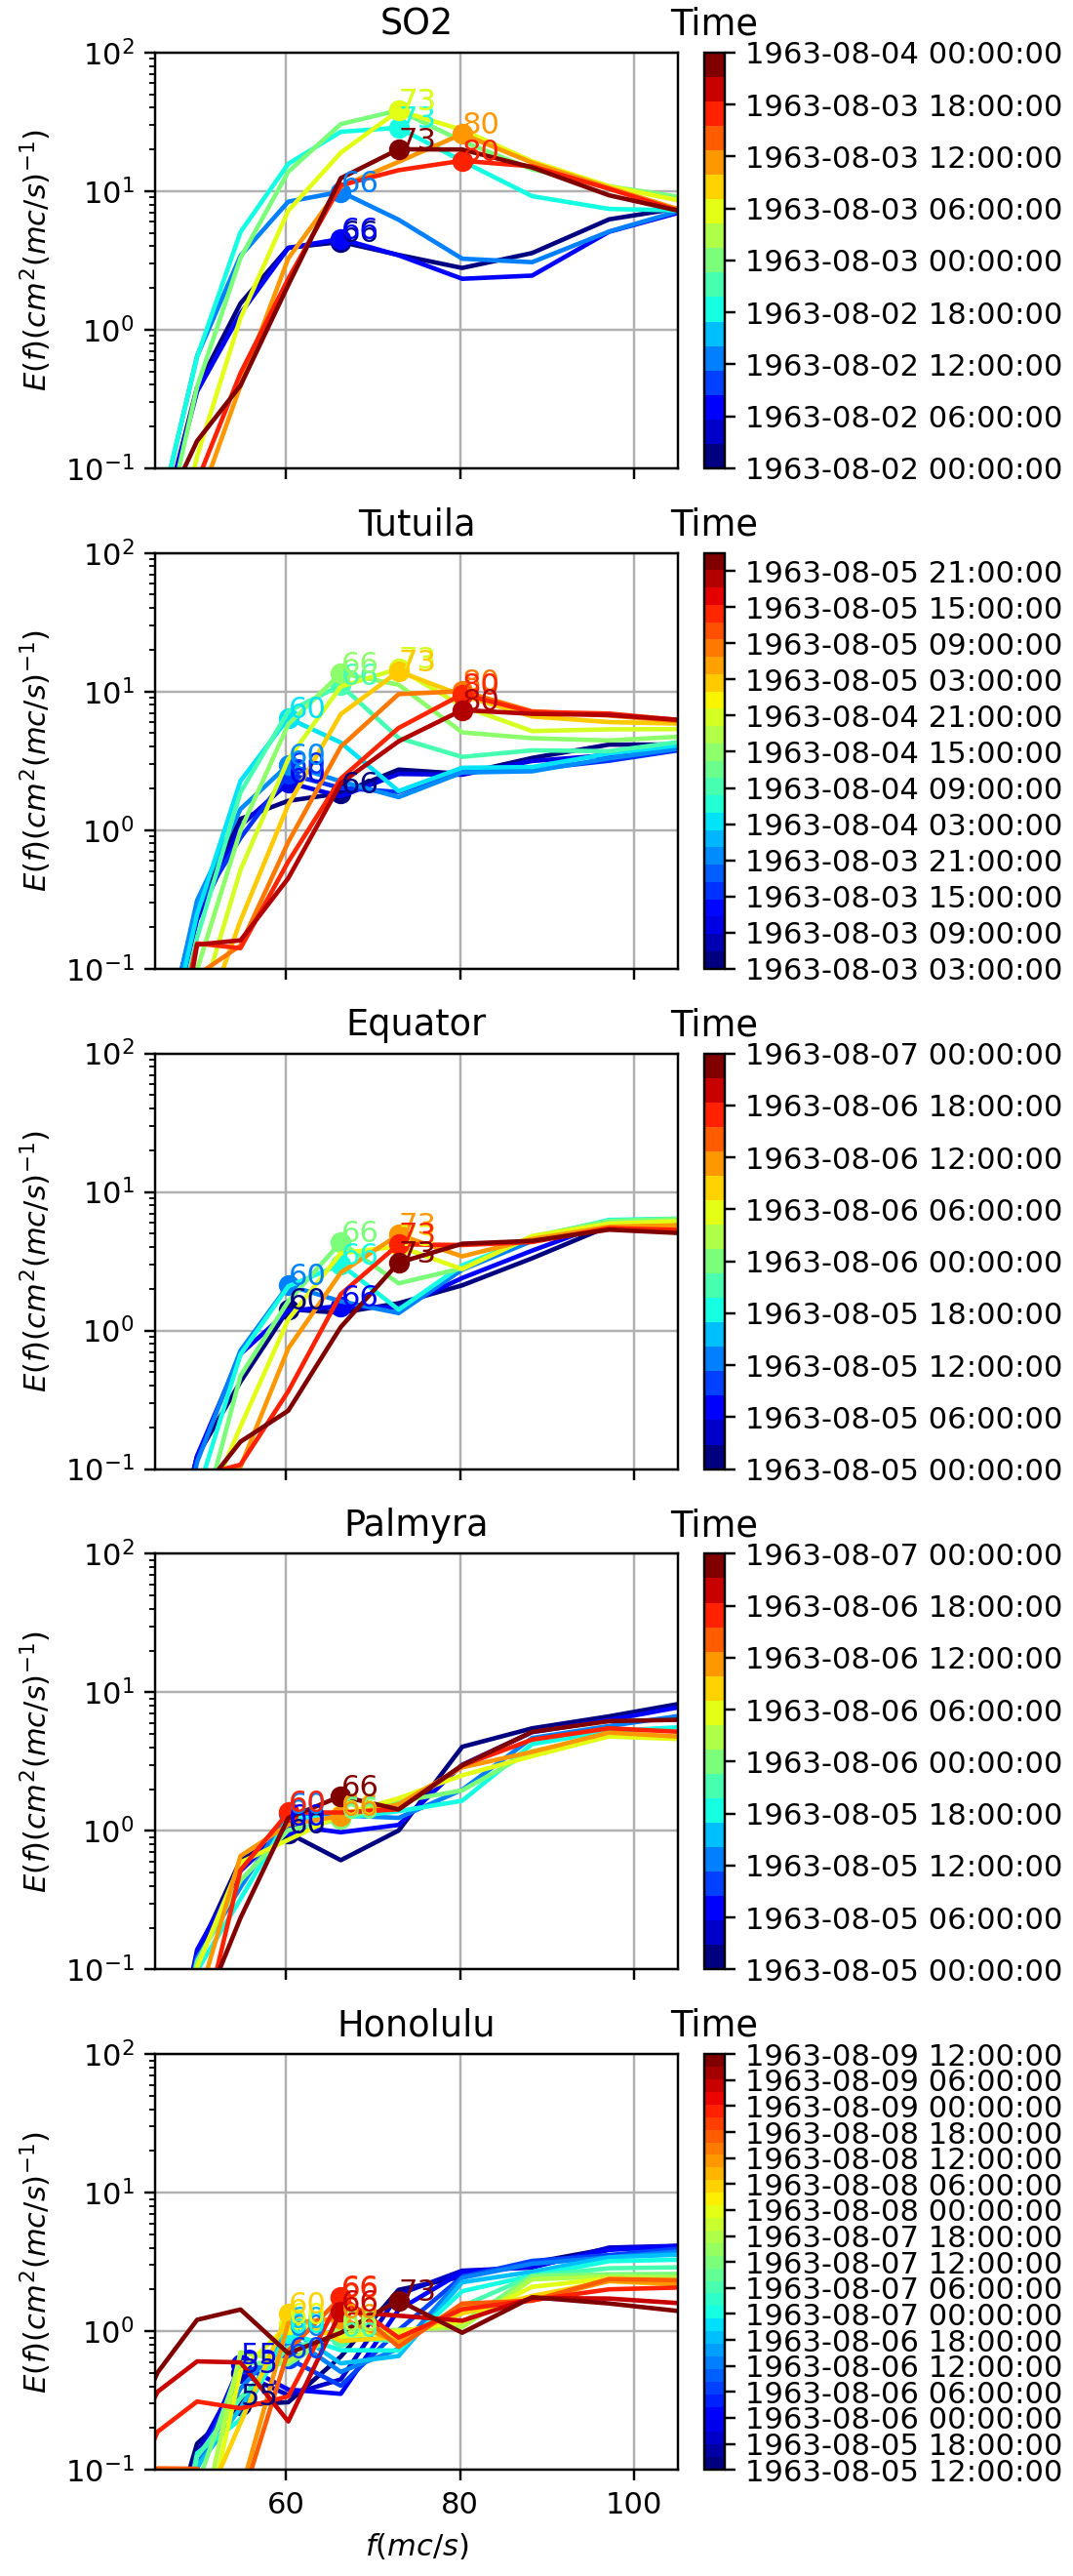

In [9]:
def plot(ax, data):
    time_arr = pd.to_datetime(data['time'][:,0]-719529,unit='d').round('s')
    cmap = mpl.cm.get_cmap('jet', data['time'].shape[0])
    c = np.arange(1,data['time'].shape[0]+1)
    dummie_cax = ax.scatter(time_arr,time_arr,c=c,cmap=cmap)
    ax.cla()

    for it in range(0,data['time'].shape[0],2): # for different times
        ax.plot(data['fre']*1000, data['efth_Ef'][:,it]*10, color=cmap(it)) # plot the spectrum 
        ax.plot(data['Fstorm'][:,it]*1000, data['Ef_Fstorm'][:,it]*10, 
                linestyle='none', marker='o', color=cmap(it)) # plot with circle the peak
        ax.text(data['Fstorm'][:,it]*1000, data['Ef_Fstorm'][:,it]*10, 
                '%.0f' %(data['Fstorm'][:,it]*1000), color=cmap(it)) # annotating the peak freq in mc/s

    cbar = fig.colorbar(dummie_cax,ticks=c[::2])
    cbar.set_ticklabels(time_arr[::2])
    ax.set_ylabel('$E(f) (cm^2 (mc/s)^{-1}$)')
    ax.set_xlim(45,105)
    ax.set_yscale('log')
    ax.set_ylim([10**(-1), 10**2])
    ax.grid(True)
    cbar.ax.set_title('Time')
    
fig, axs = plt.subplots(5, figsize=[5,12], sharex=True, constrained_layout=True)
datasets = (data_SO2, data_TUTU, data_EQ, data_PALM, data_HONO)
for i, data in enumerate(datasets):
    plot(axs[i], data)

axs[0].set_title('SO2')
axs[1].set_title('Tutuila')
axs[2].set_title('Equator')
axs[3].set_title('Palmyra')
axs[4].set_title('Honolulu')
axs[-1].set_xlabel('$f (mc/s)$')
fig.savefig('multistations.png', bbox_inches='tight')

<span style="color:blue">2.3</span>
Conside the swells of frequency 73 mc/s in the above plot. When did the swells of this particular frequency __first__ arrive at the "station" SO2? How about "station" Tutuila? Estimate the distance between the two stations using their respective latitudes. Calculate a traveling speed of the swell signal between the stations. Repeat the same exercise between "station" Tutuila and the next "station" Equator.

<span style="color:blue">2.4</span> Is the speed you got consistent with what you'd expect (based on your knowledge of the dispersion relation)? __Hint__: the wave energy actually travels at [group speed](https://www.wikiwand.com/en/Group_velocity#/Relation_to_phase_velocity,_refractive_index_and_transmission_speed) $c_g$, which is half of the phase velocity $c$ for ocean waves because of their dispersive nature. For non-dispersive waves, e.g. sound waves, $c_g=c$ (recall assignment 1 and the echolocation of bats).

<span style="color:blue">2.5</span> Take station Tutuila as an example, swells of which frequency (among 66, 73, and 80 mc/s) arrive first? This pattern repeats for the first three stations (S02, Tutuila, Equator). Why is that the case? PS: __Section 5(a)__ of the 1966 paper even gives a simple relation you can use to infer the distance from storm event location where these swells are originally generated, but you are not asked to do it here.

<span style="color:blue">2.6</span> Open question: The 1966 paper mentions that most of the swells they observe were generated by the southern hemisphere winter storms. Given that, what are the possible reasons that the last two stations (Palmyra and Honolulu) do not show clear signals of swells passing by?